In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import math
from torch.nn.modules import transformer

from torch.nn.modules.batchnorm import BatchNorm2d

## LiuzihuaNet_Trans: Vision transformer based Feature Pyramid Network for Cifar10

### implement of Vision Transformer

In [2]:
## The MIx-FFN after the Efficient Self-attention
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

# In the paper, conv the image by using the
class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        # Simple 3 by 3 convolution
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0
        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads  # Get the head dim for each attention head
        self.scale = qk_scale or head_dim ** -0.5 # Scale Normal

        self.q = nn.Linear(dim, dim, bias=qkv_bias) # Get the query Matrix
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias) # Get the Key and Value Matrix
        self.attn_drop = nn.Dropout(attn_drop)  # Use attention dropout or out
        self.proj = nn.Linear(dim, dim) # project matrix
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]
        attn =torch.matmul(q,k.transpose(-2,-1)) *self.scale
        # attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = torch.matmul(attn,v).transpose(1,2).reshape(B,N,C)
        # x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x

# Change the Image into Patch Embeddings
class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size) #(224,224)
        patch_size = to_2tuple(patch_size) #(7,7)

        self.img_size = img_size #224
        self.patch_size = patch_size #7
        # patch_index at height and path_index at width
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W

        # project here use Conv
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))

        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x) # First use projection
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W

class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=4, stride=2, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 2, patch_size=2, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=2, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=2, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        outs.append(x)  # Here is 1/2

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)  # Here is 1/4

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)  # Here is 1/8

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x) # Here is 1/16

        return outs

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class mit_b0(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160,160], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

class classification_layer(nn.Module):
    def __init__(self,num_classes=10):
        super(classification_layer, self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(64))
        self.conv2 =nn.Sequential(
            nn.Conv2d(448,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.avgpool = nn.AvgPool2d(8)
        self.fc1= nn.Linear(128,num_classes)

    def forward(self,features):
        reshape_feature = []
        traget_size = 8
        for f in features:
            if f.size(-2)<=9:
                f = F.interpolate(f,size=(8,8),mode='bilinear',align_corners=False)
                reshape_feature.append(f)
            elif f.size(-2)>9:
                f = self.conv1(f)
                f = F.interpolate(f,size=(8,8),mode='bilinear',align_corners=False)
                reshape_feature.append(f)

        new_concated_feature = torch.cat((reshape_feature[0],reshape_feature[1],reshape_feature[2],reshape_feature[3]),dim=1)
        output = self.conv2(new_concated_feature)
        output = self.avgpool(output)
        out = output.view(output.size(0), -1)
        output= self.fc1(out)
        return output
         
class new_model(nn.Module):
    def __init__(self,num_class):
        super(new_model,self).__init__()
        self.mit = mit_b0()
        self.cls_layer = classification_layer(num_classes=num_class)
    def forward(self,images):
        feature = self.mit(images)
        clcs = self.cls_layer(feature)
        return clcs




## Train the model !

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper-parameters
num_epochs = 80
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=True,transform=transform,
                      download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',train=False,transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                       shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,
                      shuffle=False)



model = new_model(num_class=10).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
summary_writer = SummaryWriter("tanaka_report/trans")

total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    # train here 
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            summary_writer.add_scalar("Current Loss: ",loss.item())
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
        summary_writer.add_scalar("Learning_Rate",curr_lr,epoch+1)
    
    # Test
    if (epoch+1)%2==0:
        print("Beigin test")
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            acc_rate = 100 * correct / total
            summary_writer.add_scalar("ACC_on_Test",acc_rate,epoch+1)
            print("test done! acc is : ",acc_rate)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'liuzihua_trans.ckpt')

cuda
Files already downloaded and verified
Epoch [1/80], Step [100/500] Loss: 1.7422
Epoch [1/80], Step [200/500] Loss: 1.5878
Epoch [1/80], Step [300/500] Loss: 1.3262
Epoch [1/80], Step [400/500] Loss: 1.2137
Epoch [1/80], Step [500/500] Loss: 1.2975
Epoch [2/80], Step [100/500] Loss: 1.1542
Epoch [2/80], Step [200/500] Loss: 1.1598
Epoch [2/80], Step [300/500] Loss: 0.9547
Epoch [2/80], Step [400/500] Loss: 0.9499
Epoch [2/80], Step [500/500] Loss: 1.0966
Beigin test
test done! acc is :  61.28
Epoch [3/80], Step [100/500] Loss: 0.8763
Epoch [3/80], Step [200/500] Loss: 1.0555
Epoch [3/80], Step [300/500] Loss: 0.8206
Epoch [3/80], Step [400/500] Loss: 0.7609
Epoch [3/80], Step [500/500] Loss: 0.6905
Epoch [4/80], Step [100/500] Loss: 0.7418
Epoch [4/80], Step [200/500] Loss: 0.7709
Epoch [4/80], Step [300/500] Loss: 0.8259
Epoch [4/80], Step [400/500] Loss: 0.8152
Epoch [4/80], Step [500/500] Loss: 0.6311
Beigin test
test done! acc is :  70.75
Epoch [5/80], Step [100/500] Loss: 0.70

Epoch [36/80], Step [200/500] Loss: 0.1544
Epoch [36/80], Step [300/500] Loss: 0.2304
Epoch [36/80], Step [400/500] Loss: 0.2174
Epoch [36/80], Step [500/500] Loss: 0.2333
Beigin test
test done! acc is :  88.99
Epoch [37/80], Step [100/500] Loss: 0.1182
Epoch [37/80], Step [200/500] Loss: 0.1865
Epoch [37/80], Step [300/500] Loss: 0.1503
Epoch [37/80], Step [400/500] Loss: 0.1805
Epoch [37/80], Step [500/500] Loss: 0.2515
Epoch [38/80], Step [100/500] Loss: 0.0800
Epoch [38/80], Step [200/500] Loss: 0.1892
Epoch [38/80], Step [300/500] Loss: 0.1694
Epoch [38/80], Step [400/500] Loss: 0.2159
Epoch [38/80], Step [500/500] Loss: 0.1432
Beigin test
test done! acc is :  89.13
Epoch [39/80], Step [100/500] Loss: 0.1304
Epoch [39/80], Step [200/500] Loss: 0.2383
Epoch [39/80], Step [300/500] Loss: 0.1200
Epoch [39/80], Step [400/500] Loss: 0.1237
Epoch [39/80], Step [500/500] Loss: 0.1121
Epoch [40/80], Step [100/500] Loss: 0.1604
Epoch [40/80], Step [200/500] Loss: 0.1413
Epoch [40/80], Step

Epoch [71/80], Step [200/500] Loss: 0.1213
Epoch [71/80], Step [300/500] Loss: 0.0633
Epoch [71/80], Step [400/500] Loss: 0.0522
Epoch [71/80], Step [500/500] Loss: 0.1383
Epoch [72/80], Step [100/500] Loss: 0.1309
Epoch [72/80], Step [200/500] Loss: 0.0558
Epoch [72/80], Step [300/500] Loss: 0.0359
Epoch [72/80], Step [400/500] Loss: 0.1160
Epoch [72/80], Step [500/500] Loss: 0.0341
Beigin test
test done! acc is :  89.97
Epoch [73/80], Step [100/500] Loss: 0.0779
Epoch [73/80], Step [200/500] Loss: 0.0580
Epoch [73/80], Step [300/500] Loss: 0.0416
Epoch [73/80], Step [400/500] Loss: 0.0310
Epoch [73/80], Step [500/500] Loss: 0.0837
Epoch [74/80], Step [100/500] Loss: 0.0469
Epoch [74/80], Step [200/500] Loss: 0.0461
Epoch [74/80], Step [300/500] Loss: 0.0777
Epoch [74/80], Step [400/500] Loss: 0.0456
Epoch [74/80], Step [500/500] Loss: 0.0384
Beigin test
test done! acc is :  89.93
Epoch [75/80], Step [100/500] Loss: 0.0569
Epoch [75/80], Step [200/500] Loss: 0.0707
Epoch [75/80], Step

## test the validaraion the acc rate on Test dataset


In [5]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'liuzihua_trans.ckpt')


# Test the model
model.eval()
predicted_result_list = []
gt_result_list= []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predict_array = predicted.cpu().numpy()
        predicted_result_list.extend(predict_array)
        gt_label =labels.cpu().numpy()
        gt_result_list.extend(gt_label)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(len(predicted_result_list))
print(len(gt_result_list))

import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt

acc = sklearn.metrics.accuracy_score(gt_result_list,predicted_result_list)

Accuracy of the model on the test images: 90.09 %
10000
10000


In [6]:
acc

0.9009

## the acc on validation -set of Cifar10 is 90.09%

## Next is the confusion Matrix

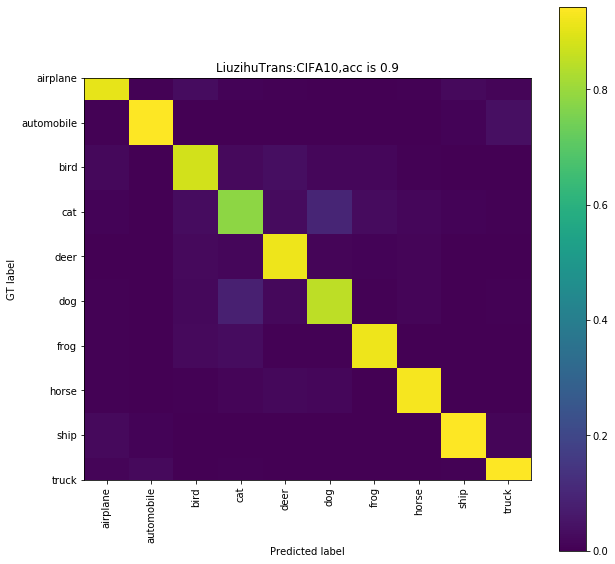

In [7]:
# get confusion matrix
def plot_confusion_matrix(cm, labels_name, title,figname):
    plt.figure(figsize=(10,10))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm, interpolation='nearest')    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    plt.ylabel('GT label')    
    plt.xlabel('Predicted label')
    plt.savefig(figname, format='png')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt
labels_name =["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
confusion_matrix = sklearn.metrics.confusion_matrix(gt_result_list,predicted_result_list)
plot_confusion_matrix(cm = confusion_matrix,labels_name=labels_name,title="LiuzihuTrans:CIFA10,acc is {}" .format(round(acc,2)), figname="LIUZIHA_tt")

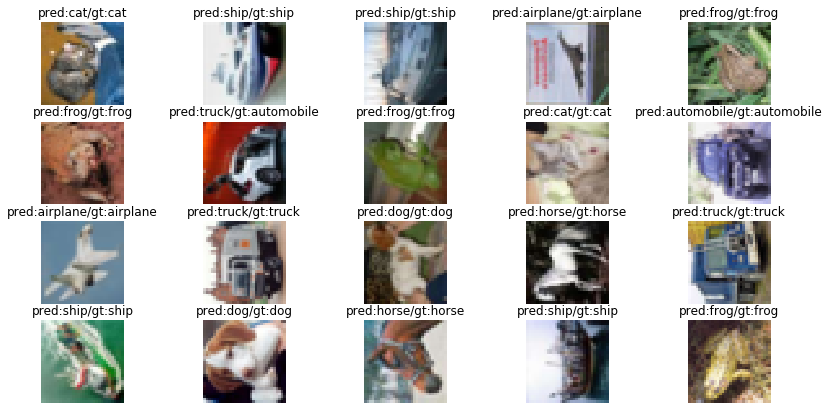

In [8]:
# Visualization
vis_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,
                      shuffle=False)
model.eval()
visuilzation_images = []
predict_labels = []
gt_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    cnt =0
    for images, labels in vis_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predict_array = predicted.cpu().numpy()
        
        gt_label =labels.cpu().numpy()
        
        vis_image = images.squeeze(0)
        vis_image = vis_image.permute(2,1,0)
        vis_image = vis_image.cpu().numpy()
        
        visuilzation_images.append(vis_image)
        predict_labels.append(predict_array[0])
        gt_labels.append(gt_label[0])
        
        cnt = cnt+1
        if cnt>19:
            break
plt.figure(figsize=(14,7))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title("pred:{}/gt:{}".format(labels_name[predict_labels[i]],labels_name[gt_labels[i]]))
    plt.axis("off")
    plt.imshow(visuilzation_images[i])
plt.savefig("predict_result_trans.png")
plt.show()
